In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from pathlib import Path

import cv2
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import skimage
import odl
import tifffile as tif
from cycler import cycler
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.generate_scan_pattern import generate_scan_pattern_by_feature_shape
from fast.utils.img_loader import renormalize
from fast.input_params import SampleParams
from tqdm.notebook import tqdm
import scipy


In [11]:
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype("bool"))
frns = lambda x, m: cv2.inpaint(x * m, 1 - m, 10, cv2.INPAINT_NS)

In [12]:
shape = np.array([128, 128])
center = shape // 2

In [13]:
space = odl.uniform_discr([-1, -1], [1, 1], shape)

[  10.   20.   30.   40.  100.]
[  10.   20.   30.   40.  100.]
[  10.   20.   30.  100.]
[  20.   30.  100.]
[  20.   30.  100.]


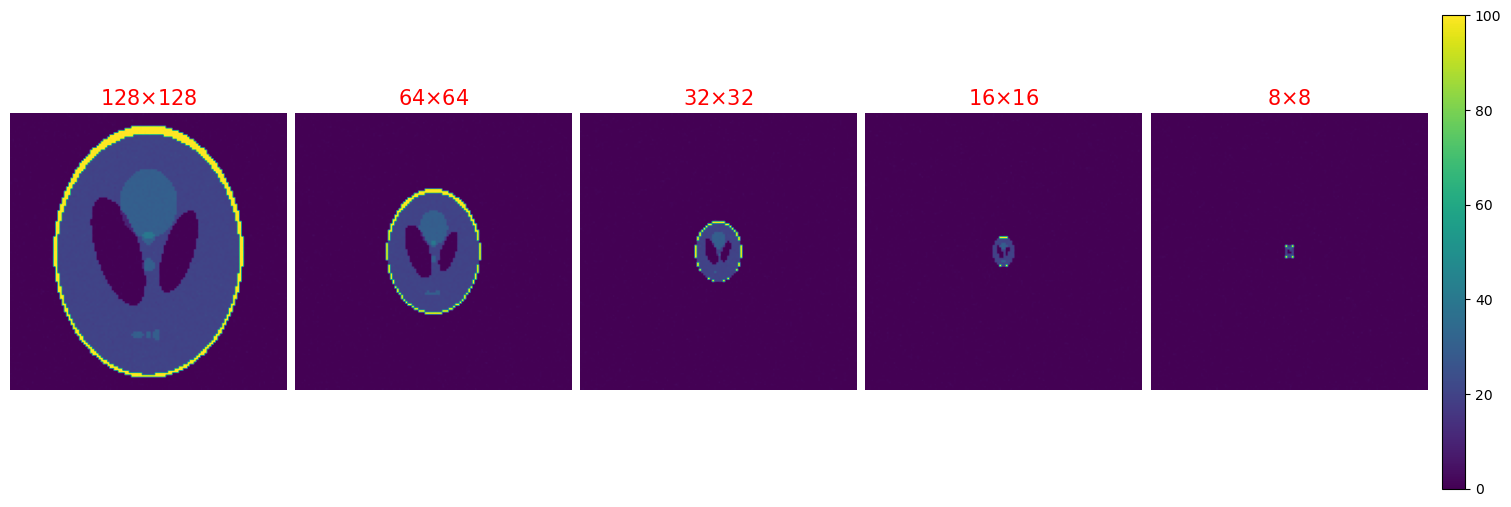

In [15]:
sps_scaled = {}
shapes_scaled = {}

fig, axs = plt.subplots(1, 5, figsize=[15, 6], constrained_layout=True)

for i in range(5):
    shape_this = shape // 2**i
    space_this = odl.uniform_discr([-1, -1], [1, 1], shape=shape // 2**i)
    sp_orig = renormalize(odl.phantom.shepp_logan(space_this, modified=True).asarray().T[::-1])

    sp_nonzero = sp_orig[sp_orig > 0]
    print(np.unique(sp_nonzero))

    sp_this = np.pad(sp_orig, [64 - shape_this // 2, 64 - shape_this // 2])
    noise_this = odl.phantom.noise.white_noise(space, stddev=0.5).asarray()
    sp_this += noise_this

    roi = [np.maximum(center[0] - shape_this[0] // 2, 0), np.minimum(center[0] + shape_this[0] // 2, shape[0])]
    label = rf"{shape_this[0]}$\times${shape_this[1]}"
    cim = axs[i].imshow(sp_this, vmin=0, vmax=100, rasterized=False)

    # axs[i].set_ylim(roi[0], roi[1])
    # axs[i].set_xlim(roi[0], roi[1])
    axs[i].set_title(label, color="red", fontsize=15)
    axs[i].axis("off")
    # plt.gca().clabel(cs, cs.levels, inline=True,  fontsize=10)
    # plt.gca().invert_yaxis()
    # axs[1,i].imshow(sp_this, vmin=0, vmax=100)

    sps_scaled[i] = renormalize(sp_this)
    shapes_scaled[i] = shape_this
# fig.suptitle("Resized Shepp-Logan phantoms", fontsize=17)
fig.colorbar(ax=axs, mappable=cim, pad=0.01, shrink=0.8, use_gridspec=True, aspect=20)
plt.savefig(f"{base_dir}/ground.svg", bbox_inches="tight", transparent=True, dpi=400)
# plt.savefig(f"{base_dir}/ground.pdf", bbox_inches="tight", transparent=True, dpi=400)
plt.show()

In [7]:
base_dir = Path("features_sizes")

In [8]:
load_fname = base_dir / "data_all.joblib"

In [9]:
data_per_label = joblib.load(load_fname)

In [10]:
markers = cycler(marker=[".", "o", "D", "<", "s", "P", "X", "D", 9, 10, "d"])
linestyle_tuple = ls = [
    ("loosely dotted", (0, (1, 10))),
    ("dotted", (0, (1, 1))),
    ("densely dotted", (0, (1, 1))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("dashed", (0, (5, 5))),
    ("densely dashed", (0, (5, 1))),
    ("dashdotted", (0, (3, 5, 1, 5))),
    ("densely dashdotted", (0, (3, 1, 1, 1))),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
]
ls_cycler = [l[1] for l in linestyle_tuple]
prop_cycler = markers + cycler(ls=ls_cycler)

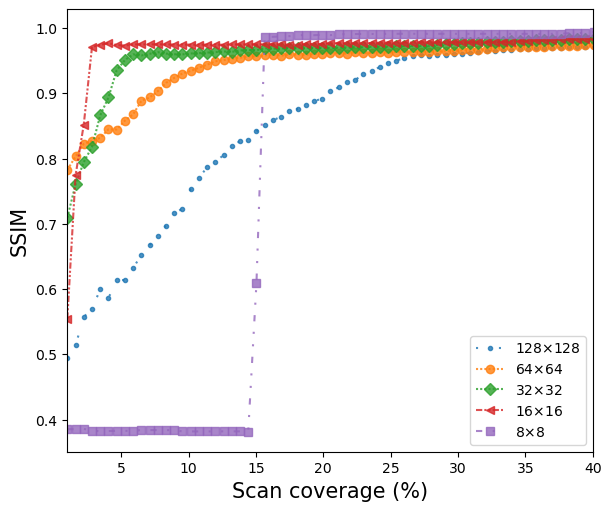

In [56]:
pc = prop_cycler()
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    label = rf"{shape_this[0]}$\times${shape_this[1]}"
    plt.plot(data_per_label[k]["scan_ratios"] * 100, data_per_label[k]["ssims"], label=label, **next(pc), alpha=0.8)

plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("SSIM", fontsize=15)
plt.legend(loc="best")

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
plt.xlim([1, 40])
# plt.savefig(f"{base_dir}/ssims.svg", bbox_inches="tight", dpi=600)
plt.savefig(f"{base_dir}/ssims.pdf", bbox_inches="tight", dpi=600)
plt.show()

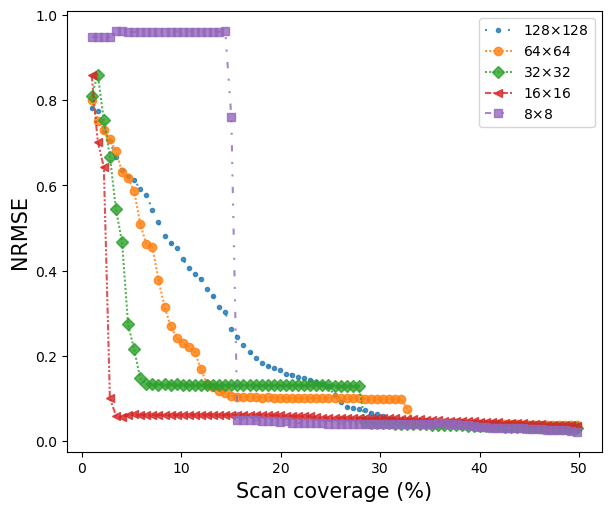

In [55]:
pc = prop_cycler()
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    label = rf"{shape_this[0]}$\times${shape_this[1]}"
    plt.plot(data_per_label[k]["scan_ratios"] * 100, data_per_label[k]["rmses"], label=label, **next(pc), alpha=0.8)


plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("NRMSE", fontsize=15)
plt.legend(loc="best")

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
# plt.xlim([1, 40])
# plt.savefig(f"{base_dir}/nrmses.svg", bbox_inches="tight", dpi=600)
plt.savefig(f"{base_dir}/nrmses.pdf", bbox_inches="tight", dpi=600)
plt.show()

In [44]:
ratios_to_plot = [14, 16]
indices = [np.argmin(np.abs(data_per_label[0]["scan_ratios"] * 100 - r)) for r in ratios_to_plot]

In [45]:
indices

[21, 25]

In [46]:
center = shape // 2

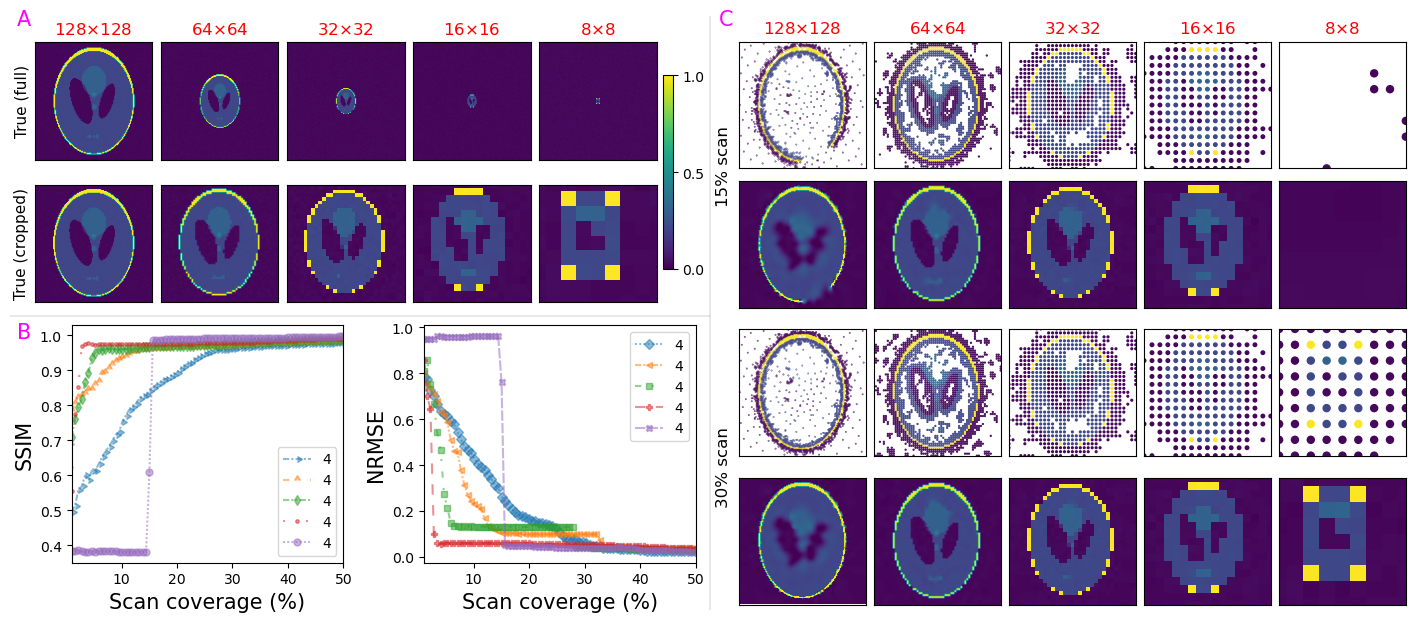

In [124]:
cmap = mpl.colormaps.get_cmap("viridis").copy()
norm = plt.Normalize(0, 1)

fig = plt.figure(figsize=[14, 6], constrained_layout=True)
gs = fig.add_gridspec(4, 10)

sf1 = fig.add_subfigure(gs[:2, :5])
axs = sf1.subplots(2, 5)

iy = 0
for label in data_per_label:
    shape_this = shapes_scaled[label]
    roi = [np.maximum(center[0] - shape_this[0] // 2, 0), np.minimum(center[0] + shape_this[0] // 2, shape[0])]

    title = rf"{shape_this[0]}$\times${shape_this[1]}"
    sp_this = sps_scaled[label] / 100
    cim = axs[0, iy].imshow(sp_this, norm=norm, cmap=cmap, rasterized=False)
    axs[0, iy].set_title(title, color="red")  # , fontsize=12)

    axs[1, iy].imshow(sp_this, norm=norm, cmap=cmap, rasterized=False)
    axs[1, iy].set_xlim(roi[0], roi[1])
    axs[1, iy].set_ylim(roi[1], roi[0])

    if iy == 0:
        axs[0, iy].set_ylabel("True (full)", fontsize=11, x=0.01)
        axs[1, iy].set_ylabel("True (cropped)", fontsize=11, x=0.01)

    iy += 1
plt.setp(axs, yticks=[])
plt.setp(axs, xticks=[])
cbar = sf1.colorbar(cim, ax=axs, shrink=0.7, pad=0.01, location="right")
cbar.ax.set_yticks([0, 0.5, 1.0])

sf2 = fig.add_subfigure(gs[2:, :5])
sp = sf2.add_subplot(121)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    title = rf"{shape_this[0]}$\times${shape_this[1]}"
    sp.plot(
        data_per_label[k]["scan_ratios"] * 100,
        data_per_label[k]["ssims"],
        label=label,
        **next(pc),
        alpha=0.5,
        markersize=5,
    )
plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("SSIM", fontsize=15)
plt.legend(loc="best")
plt.xlim([1, 50])

sp = sf2.add_subplot(122)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    title = rf"{shape_this[0]}$\times${shape_this[1]}"
    sp.plot(
        data_per_label[k]["scan_ratios"] * 100,
        data_per_label[k]["rmses"],
        label=label,
        **next(pc),
        alpha=0.5,
        markersize=5,
    )

plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("NRMSE", fontsize=15)
plt.legend(loc="best")
plt.xlim([1, 50])

sf3 = fig.add_subfigure(gs[:2, 5:])
axs2 = sf3.subplots(2, 5)
iy = 0
for label in data_per_label:
    shape_this = shapes_scaled[label]
    roi = [np.maximum(center[0] - shape_this[0] // 2, 0), np.minimum(center[0] + shape_this[0] // 2, shape[0])]
    title = rf"{shape_this[0]}$\times${shape_this[1]}"

    mask = data_per_label[label]["masks"][indices[0]]
    recons = data_per_label[label]["recons_bh"][indices[0]] / 100
    ypoints, xpoints = np.where(mask)
    ints = recons[ypoints, xpoints]

    axs2[0, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.1 * 4**iy, rasterized=False, zorder=0)
    cim = axs2[1, iy].imshow(recons, norm=norm, cmap=cmap, rasterized=False)

    axs2[0, iy].set_title(title, color="red")  # , fontsize=12)
    cim = axs2[1, iy].imshow(recons, norm=norm, cmap=cmap, rasterized=False)
    plt.setp(axs2[:, iy], xlim=[roi[0], roi[1]], ylim=[roi[1], roi[0]])

    iy += 1

plt.setp(axs2, xticks=[])
plt.setp(axs2, yticks=[])
plt.setp(axs2, aspect="equal")
sf3.supylabel("15% scan")


sf4 = fig.add_subfigure(gs[2:, 5:])
axs3 = sf4.subplots(2, 5)
iy = 0
for label in data_per_label:
    shape_this = shapes_scaled[label]
    roi = [np.maximum(center[0] - shape_this[0] // 2, 0), np.minimum(center[0] + shape_this[0] // 2, shape[0])]

    mask = data_per_label[label]["masks"][indices[1]]
    recons = data_per_label[label]["recons_bh"][indices[1]] / 100
    ypoints, xpoints = np.where(mask)
    ints = recons[ypoints, xpoints]

    axs3[0, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.1 * 4**iy, rasterized=False, zorder=0)
    cim = axs3[1, iy].imshow(recons, norm=norm, cmap=cmap, rasterized=False)
    plt.setp(axs3[:, iy], xlim=[roi[0], roi[1]], ylim=[roi[1], roi[0]])

    iy += 1

plt.setp(axs3, xticks=[])
plt.setp(axs3, yticks=[])
plt.setp(axs3, aspect="equal")
sf4.supylabel("30% scan")

line1 = plt.Line2D([0.5, 0.5], [0.01, 1.0], transform=fig.transFigure, color="black", linewidth=0.2, alpha=0.6)
fig.add_artist(line1)

line2 = plt.Line2D([0.0, 0.5], [0.5, 0.5], transform=fig.transFigure, color="black", linewidth=0.2, alpha=0.6)
fig.add_artist(line2)

sf1.text(0.01, 0.97, "A", fontsize=15, color="magenta")
sf2.text(0.01, 0.93, "B", fontsize=15, color="magenta")
sf3.text(0.01, 0.97, "C", fontsize=15, color="magenta")

plt.savefig(f"{base_dir}/comparisons_multiple.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

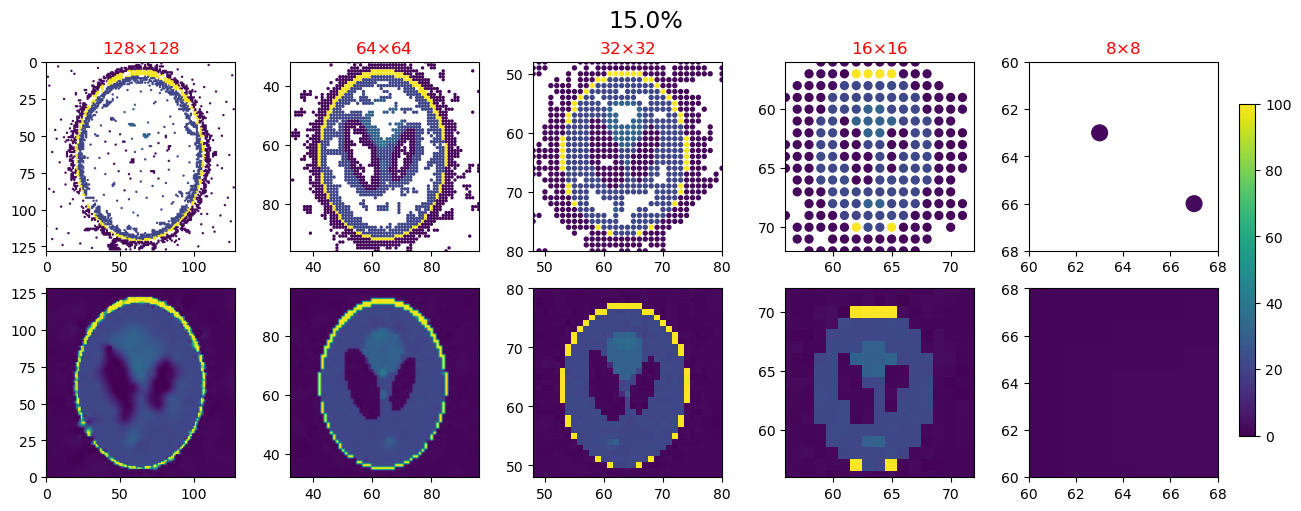

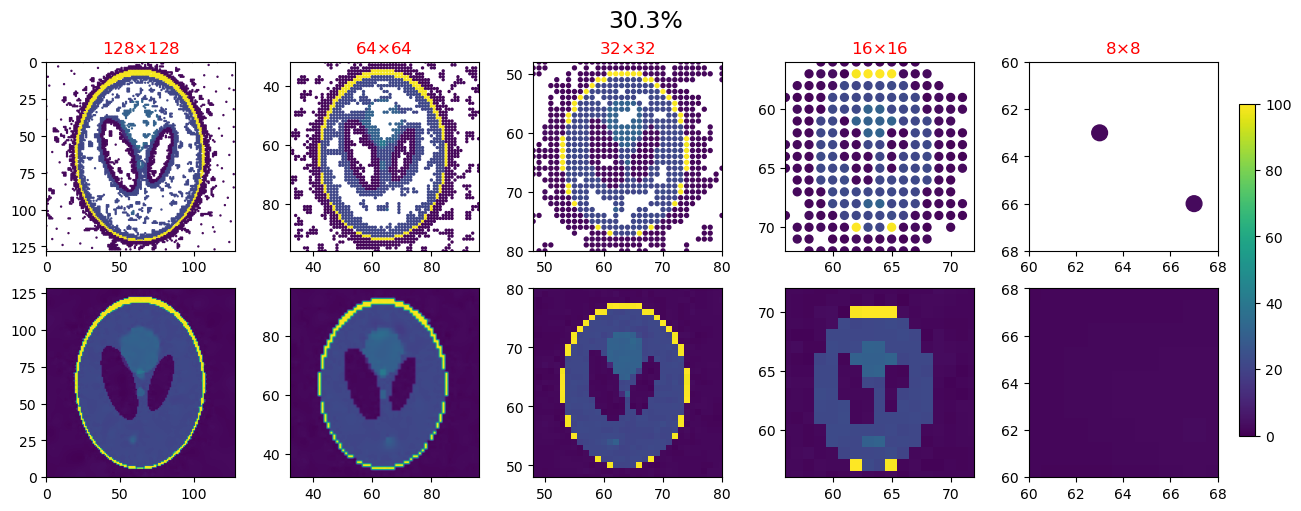

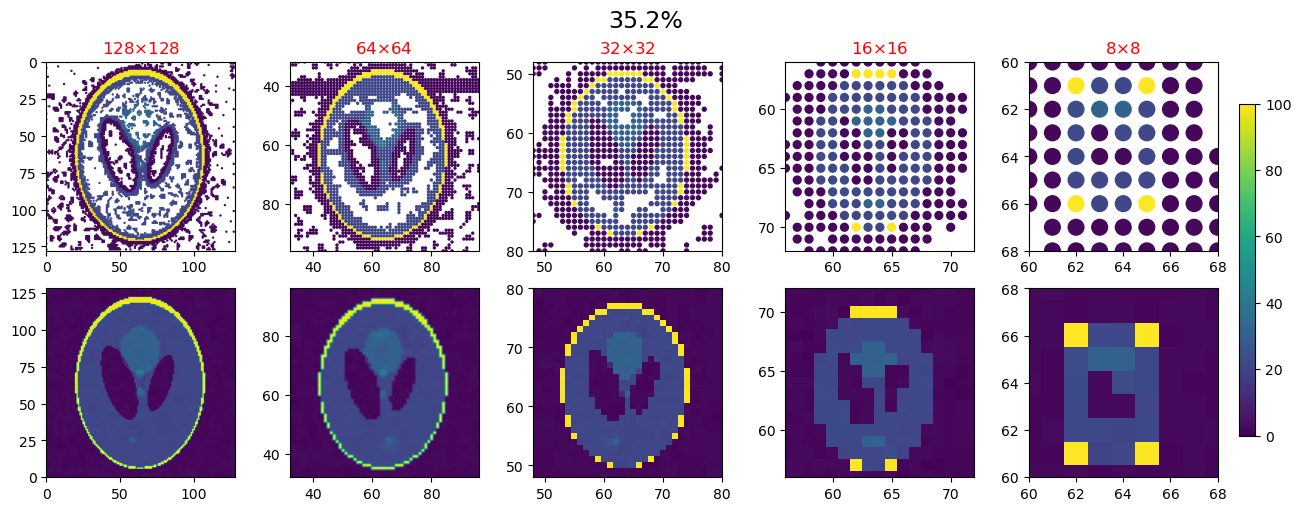

In [62]:
for ix, sr in enumerate(data_per_label[0]["scan_ratios"]):
    r_perc = sr * 100
    if ix not in indices:
        continue
    # if sr > 0.3 or ix==0: continue
    # if ix % 2 != 0: continue
    fig, axs = plt.subplots(2, 5, figsize=[13, 5], constrained_layout=True)
    cmap = mpl.colormaps.get_cmap("viridis").copy()
    norm = plt.Normalize(0, 100)
    for iy, label in enumerate(data_per_label):
        shape_this = shapes_scaled[label]
        roi = [np.maximum(center[0] - shape_this[0] // 2, 0), np.minimum(center[0] + shape_this[0] // 2, shape[0])]

        mask = data_per_label[label]["masks"][ix]  # [roi[0]: roi[1], roi[0]: roi[1]]
        recons = data_per_label[label]["recons_bh"][ix]  # [roi[0]: roi[1], roi[0]: roi[1]] / 100

        ypoints, xpoints = np.where(mask)

        ints = recons[ypoints, xpoints]

        # help(mpl.colors.Normalize)
        # raise

        # axs[0, iy].imshow(, rasterized=True)
        shape_this = shapes_scaled[iy]
        label = rf"{shape_this[0]}$\times${shape_this[1]}"
        axs[0, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.5 * 4**iy, rasterized=True, zorder=0)
        axs[0, iy].set_title(label, c="r")
        axs[0, iy].set_ylim(roi[0], roi[1])
        axs[0, iy].set_xlim(roi[0], roi[1])
        axs[0, iy].set_aspect("equal")
        axs[0, iy].invert_yaxis()
        # axs[0, iy].axis('off')

        cim = axs[1, iy].imshow(
            recons[::-1],
            cmap=cmap,
            norm=norm,
            rasterized=True,
        )
        axs[1, iy].set_ylim(roi[0], roi[1])
        axs[1, iy].set_xlim(roi[0], roi[1])
        # axs[1, iy].axis('off')
    fig.suptitle(f"{sr * 100:3.1f}%", fontsize=17)
    fig.colorbar(cim, ax=axs, shrink=0.8, pad=0.01)
    # plt.savefig(f"{base_dir}/comparisons_{r_perc:3.0f}.svg", bbox_inches="tight", dpi=400, transparent=True)
    plt.savefig(f"{base_dir}/comparisons_{r_perc:3.0f}.pdf", bbox_inches="tight", dpi=400, transparent=True)
    plt.show()